### Extract spike timeseries aligned to specific event for every unit

In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *
import scipy.io
from config import dir_config, ephys_config
from src.utils import ephys_utils
import pickle
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.io
from scipy.ndimage import gaussian_filter1d

# Function to align and convolve spike trains
def get_aligned_spike_trains(cluster_spike_time, timestamps, trial_info, alignment_settings, alignment_buffer, sampling_rate=30, sigma=10):
    result = {
        event: {
            'spike_trains': None,
            'convolved_spike_trains': None
        }
        for event in alignment_settings.keys()
    }

    # Prepare arrays for all alignment events
    for event_name in alignment_settings.keys():
        n_trials = len(trial_info)
        duration = alignment_settings[event_name]['end_time_ms'] - alignment_settings[event_name]['start_time_ms'] + 2 * alignment_buffer + 1

        spike_trains = np.zeros((n_trials, duration), dtype=np.float32)
        convolved_spike_trains = np.zeros((n_trials, duration), dtype=np.float32)

        # Iterate through trials
        for idx_trial, trial_num in enumerate(trial_info.index):
            if np.isnan(trial_info.reaction_time[trial_num]):
                spike_trains[idx_trial,:] *= np.nan
                convolved_spike_trains[idx_trial,:] *= np.nan
                continue

            aligned_event_time = timestamps.loc[trial_num, event_name]
            start_timestamp = aligned_event_time + (alignment_settings[event_name]['start_time_ms'] - alignment_buffer) * sampling_rate
            end_timestamp = aligned_event_time + (alignment_settings[event_name]['end_time_ms'] + alignment_buffer) * sampling_rate

            # Filter spike times from start_timestamp to end_timestamp
            temp_spike_times = cluster_spike_time[
                (cluster_spike_time >= start_timestamp) & (cluster_spike_time <= end_timestamp)
            ] - start_timestamp

            spike_idx = np.ceil(temp_spike_times / sampling_rate).astype(int)
            spike_trains[idx_trial, spike_idx] = 1
            # Convolve spike trains
            convolved_spike_trains[idx_trial,:] = gaussian_filter1d(spike_trains[idx_trial,:], sigma=sigma, truncate=3)

            # Handle special case: exclude spikes after 50ms pre-saccade
            if event_name == 'stimulus_onset':
                response_onset_time = timestamps.loc[trial_num, 'response_onset']
                if (end_timestamp-alignment_buffer*30) > response_onset_time - 50*sampling_rate:
                    pre_saccade_idx = np.ceil((response_onset_time- start_timestamp) / sampling_rate - 50).astype(int)
                    spike_trains[idx_trial, pre_saccade_idx:] = np.nan
                    convolved_spike_trains[idx_trial,pre_saccade_idx:] = np.nan

            # Handle special case: exclude spikes before stimulus onset
            elif event_name == 'response_onset':
                stim_onset_time = timestamps.loc[trial_num, 'stimulus_onset']
                stim_on_idx = max(0, np.ceil((stim_onset_time - start_timestamp) / sampling_rate + alignment_buffer).astype(int))
                spike_trains[idx_trial, :stim_on_idx] = np.nan
                convolved_spike_trains[idx_trial, :stim_on_idx] = np.nan


        # Trim buffers
        spike_trains = spike_trains[:, alignment_buffer:-alignment_buffer]
        convolved_spike_trains = convolved_spike_trains[:, alignment_buffer:-alignment_buffer] * 1000

        # Store results
        result[event_name]['spike_trains'] = spike_trains
        result[event_name]['convolved_spike_trains'] = convolved_spike_trains

    return result



# Load neuron metadata
neuron_metadata = pd.read_csv(Path(compiled_dir, "neuron_metadata.csv"), index_col=None)
ephys_neuron_wise = {event: {} for event in ephys_config.alignment_settings_GP.keys()}

# Main loop for each neuron
for neuron in neuron_metadata.neuron_id:
    session_name = neuron_metadata.session_id[neuron - 1]
    cluster_id = neuron_metadata.cluster[neuron - 1]

    # Load required data
    timestamps_path = Path(compiled_dir, session_name, f"{session_name}_timestamps.csv")
    trial_info_path = Path(compiled_dir, session_name, f"{session_name}_trial.csv")
    spike_times_path = Path(compiled_dir, session_name, "spike_times.npy")
    spike_clusters_path = Path(compiled_dir, session_name, "spike_clusters.npy")
    spike_times_mat_path = Path(compiled_dir, session_name, "spike_times.mat")
    spike_clusters_mat_path = Path(compiled_dir, session_name, "spike_clusters.mat")

    if not (timestamps_path.is_file() and trial_info_path.is_file()):
        print(f"Missing files for session: {session_name}")
        continue

    timestamps = pd.read_csv(timestamps_path, index_col=None)
    trial_info = pd.read_csv(trial_info_path, index_col=None)

    # Load spike data
    if spike_times_path.is_file() and spike_clusters_path.is_file():
        spike_times = np.load(spike_times_path)
        spike_clusters = np.load(spike_clusters_path)
    elif spike_times_mat_path.is_file() and spike_clusters_mat_path.is_file():
        spike_times = scipy.io.loadmat(spike_times_mat_path)['spike_times'].ravel()
        spike_clusters = scipy.io.loadmat(spike_clusters_mat_path)['spike_clusters'].ravel()
    else:
        print(f"Spike times and clusters not found in {session_name} for neuron {neuron}")
        continue

    # Filter spike times for the current cluster
    cluster_spike_time = spike_times[spike_clusters == cluster_id]
    GP_trial_info = trial_info[(trial_info.task_type == 1)]# & (~np.isnan(trial_info.reaction_time))]

    # Get aligned and convolved spike trains
    results = get_aligned_spike_trains(
        cluster_spike_time, timestamps, GP_trial_info,
        ephys_config.alignment_settings_GP, ephys_config.alignment_buffer
    )

    # Save results
    for event_name in ephys_config.alignment_settings_GP.keys():
        ephys_neuron_wise[event_name][neuron]={
            "spike_trains": results[event_name]['spike_trains'],
            "convolved_spike_trains": results[event_name]['convolved_spike_trains'],
            "trial_number": GP_trial_info.trial_number
        }

In [37]:

# with open(Path(processed_dir, "ephys_neuron_wise.pkl"), 'wb') as handle:
#     pickle.dump(ephys_neuron_wise, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
session_metadata = pd.read_csv(Path(compiled_dir, 'sessions_metadata.csv'))
session_metadata = session_metadata[session_metadata["session_id"] != "241209_GP_TZ"]

neuron_metadata = pd.read_csv(Path(compiled_dir, 'neuron_metadata.csv'))

with open(Path(processed_dir, f'glm_hmm_all_trials_prior_based_initialization_final.pkl'), 'rb') as f:
    glm_hmm = pickle.load(f)

# with open(Path(processed_dir, f'ephys_neuron_wise.pkl'), 'rb') as f:
#     ephys = pickle.load(f)

In [86]:
def plot_PSTH(neuron_id, condition_dict, alignment_dict = ephys_config["alignment_settings_GP"]):
    session_id = neuron_metadata.session_id[neuron_metadata.neuron_id == neuron_id].values[0]
    trial_info = glm_hmm["session_wise"]["data"]
    
    _, ax = plt.subplots(1, len(alignment_dict), figsize=(15, 5))
    for align_idx, (alignment,_) in enumerate(alignment_dict.items()):
        
        conditions = {
            "coh_0_choice_toRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0, 1),
            "coh_6_choice_toRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0.06, 1, 1),
            "coh_20_choice_toRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0.2, 1, 1),
            "coh_50_choice_toRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0.5, 1, 1),
            "coh_0_choice_awayRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0, 0),
            "coh_6_choice_awayRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0.06, 0, 1),
            "coh_20_choice_awayRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0.2, 0, 1),
            "coh_50_choice_awayRF_corr": ephys_utils.get_trial_num(trial_info[session_id], 0.5, 0, 1),
        }
        for (condition, plot_params) in condition_dict.items():
            trials = conditions[condition]
            condition_data = ephys_utils.get_neural_data_from_trial_num(ephys[alignment][neuron_id], trials, type="convolved_spike_trains")
            if alignment == "stimulus_onset":
                index = np.where(np.isin(trial_info[session_id]["trial_num"], trials))[0]
                median_reaction_time = np.nanmedian(trial_info[session_id]["reaction_time"].iloc[index])
                ax[align_idx].plot(np.nanmean(condition_data, axis=0)[:int(median_reaction_time-alignment_dict[alignment]["start_time_ms"])+1], label=condition, color=plot_params["color"], linestyle=plot_params["linestyle"])
            else:
                ax[align_idx].plot(np.nanmean(condition_data, axis=0), label=condition, color=plot_params["color"], linestyle=plot_params["linestyle"])
            ylim = ax[align_idx].get_ylim()
            ax[align_idx].vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)
            ax[align_idx].set_title(alignment)
            if alignment == "response_onset":
                ax[align_idx].set_xticks(np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, 50), 
                                    labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"] + 1, 50))
            else:
                ax[align_idx].set_xticks(np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, 100), 
                                    labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"] + 1, 100))
    
    ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

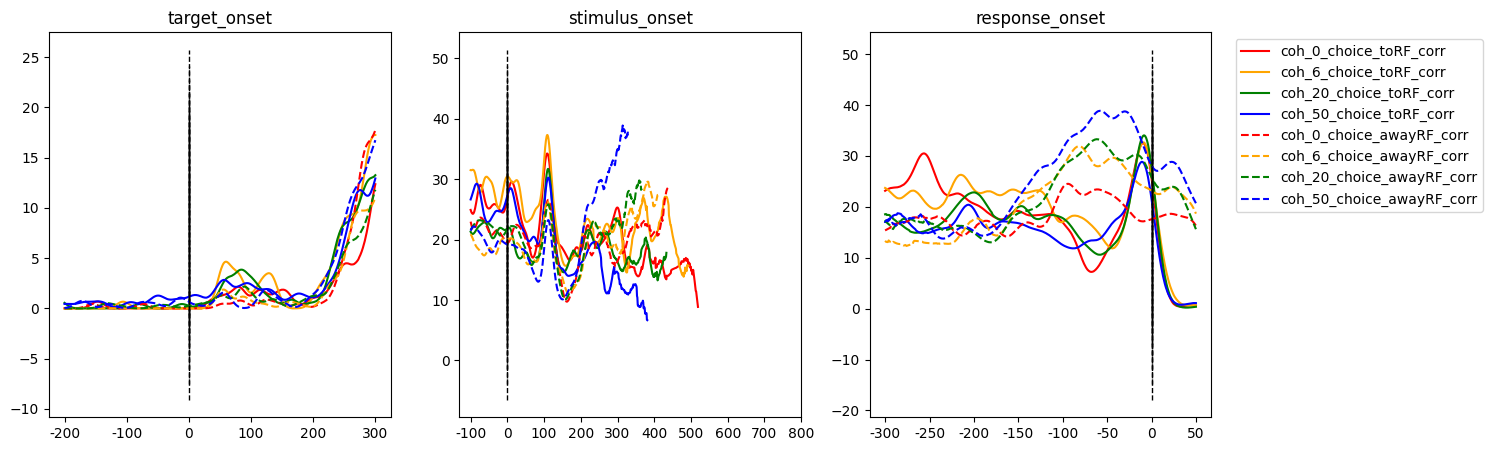

In [87]:
condition_dict = {
        "coh_0_choice_toRF_corr": {"index": 0, "color": "red", "linestyle":"-", "opacity": 1},
        "coh_6_choice_toRF_corr": {"index": 1, "color": "orange", "linestyle":"-", "opacity": 1},
        "coh_20_choice_toRF_corr": {"index": 2, "color": "green", "linestyle":"-", "opacity":1},
        "coh_50_choice_toRF_corr": {"index": 3, "color": "blue", "linestyle":"-", "opacity": 1},
        "coh_0_choice_awayRF_corr": {"index": 4, "color": "red", "linestyle":"--", "opacity": 0.3},
        "coh_6_choice_awayRF_corr": {"index": 5, "color": "orange", "linestyle":"--", "opacity": 0.3},
        "coh_20_choice_awayRF_corr": {"index": 6, "color": "green", "linestyle":"--", "opacity": 0.3},
        "coh_50_choice_awayRF_corr": {"index": 7, "color": "blue", "linestyle":"--", "opacity": 0.3},
    }
plot_PSTH(1, condition_dict, alignment_dict = ephys_config["alignment_settings_GP"])